In [1]:
%load_ext autoreload
%autoreload 2
!python -m pip install pytorch-lightning

In [2]:
from templates import *

/home/user/Imperial-Individual-Project/diffae/metrics.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [3]:
device = 'cuda'
conf = luna16_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device)

Global seed set to 0


Model params: 86.87 M


BeatGANsAutoencModel(
  (time_embed): TimeStyleSeperateEmbed(
    (time_embed): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (style): Identity()
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=128, bias=True)
        )
        (cond_emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=64, bias=True)

In [4]:
# data = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
# Prepare training and test dataset
LESION_PATH = "/home/user/data/prior_train/gt/"
# LESION_FREE_PATH = "/home/user/data/prior_train/lesion-free"
LESION_FREE_PATH = "/home/user/data/prior_train/inpainted/"
batch = Luna16Dataset(LESION_PATH, LESION_FREE_PATH)

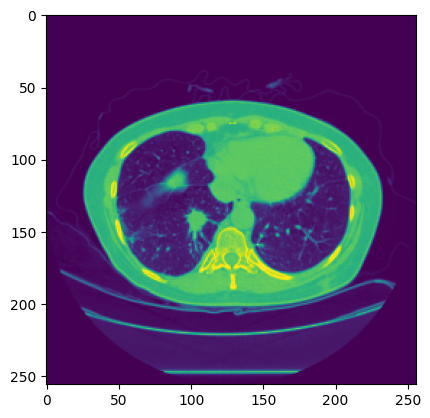

In [5]:
import matplotlib.pyplot as plt
plt.imshow(batch[0][0][0] / 2 + 0.5)

# Encode

In [6]:
b = []
lesion_free = []
idxs = []
for i in range(10):
  temp, lf, idx = batch[i]
  b.append(temp)
  lesion_free.append(lf)
  idxs.append(idx)
  
b = torch.stack(b)
cond = model.encode(b.to(device))
xT = model.encode_stochastic(b.to(device), cond, T=250)

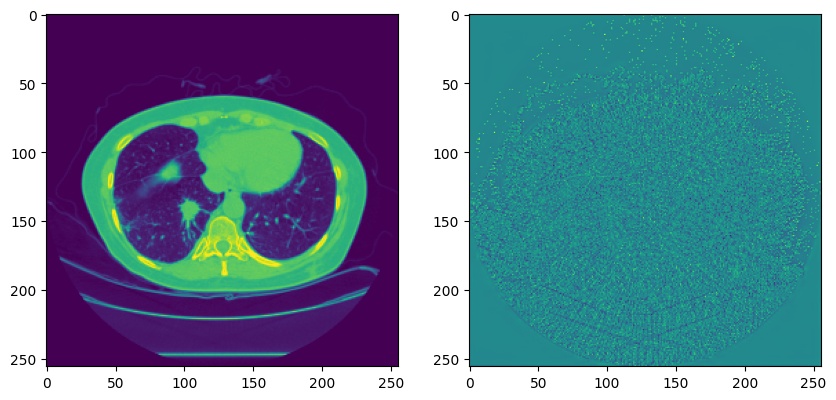

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (b + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

# Decode

0


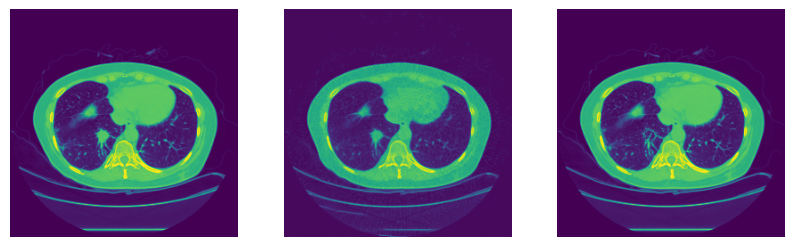

In [14]:
pred = model.render(xT, cond, T=20)
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ori = (b + 1) / 2
for i in ax:
  i.set_axis_off()

print(idxs[0])
ax[0].imshow(ori[0][0].cpu())
ax[1].imshow(pred[0][0].cpu())
ax[2].imshow(lesion_free[0][0].cpu())